## Importing Libraries

In [1]:
import os #will be used for creating directories, etc.

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import DataFrame

import torch
import torchvision
import torchvision.datasets as dsets             #for downloading dataset
import torchvision.transforms as transforms      #for transforming dataset into tensors

from torch import nn
from torch.autograd import Variable
import torchvision.transforms.functional as fn

from PIL import Image

from time import time

## Uploading Data

In [2]:
train_data = pd.read_csv('archive/peopleDevTrain.csv')

no_of_diff_people = train_data.shape[0]

print('number of different names', train_data.shape[0])
print(train_data.iloc[278,0])

number of different names 4038
Arnold_Schwarzenegger


In [3]:
img = Image.open("archive/lfw-deepfunneled/lfw-deepfunneled/Aaron_Eckhart/Aaron_Eckhart_0001.jpg")

red_dim = 64
img = fn.resize(img, size=[red_dim, red_dim])

img

convert_tensor = transforms.Compose([
    transforms.ToTensor()
])

convert_tensor(img)

print(img.size)

(64, 64)


In [4]:
def img2tensor (filepath):
    img = Image.open(filepath)
    img = fn.resize(img, size=[red_dim, red_dim])
    image = convert_tensor(img)
    return image

In [5]:
trial_number = 100
image = torch.tensor(np.zeros(shape= (trial_number,3,red_dim,red_dim)))
for number in range(trial_number):
    name = train_data.iloc[number,0]
    no_of_images = train_data.iloc[number,1]
#     print(name)
#     print(no_of_images)

    for i in range(no_of_images):
        path = "archive/lfw-deepfunneled/lfw-deepfunneled/"
        photo_number = i+1
        if i < 9:
            file_path = path + name + '/'+ name + '_000'  + str(photo_number) +'.jpg'
        elif i>9:
            file_path = path + name + '/'+ name + '_00'  + str(photo_number) +'.jpg'
        else:
            break
            
#         file_path = path + name + '/'+ name + '_0001' +'.jpg'
        image[number,:,:,:] = img2tensor(file_path)
#         print(image.size())


torch.Size([3, 64, 64])


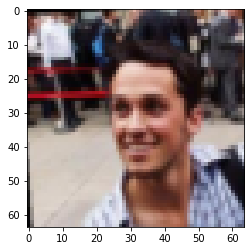

In [6]:
trial_image = image[trial_number-1,:,:,:]
print(trial_image.size())
plt.imshow(trial_image.permute(1, 2, 0)  )

In [7]:
def to_var(x):
    if torch.cuda.is_available():
        x = x.dtype(float32)
    return Variable(x)

In [8]:
image = to_var(image.view(image.size(0), -1))
print(image.size())
# image = torch.flatten(image)
print(image.size())
input_dim = image.size()

torch.Size([100, 12288])
torch.Size([100, 12288])


## Training Parameters

## Create Auto Encoder

In [9]:
class Autoencoder(nn.Module):
    def __init__(self, in_dim=3*red_dim*red_dim, h_dim=100):
        super(Autoencoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(in_dim, h_dim*2),
            nn.ReLU(),
            nn.Linear(h_dim*2, h_dim),
            nn.ReLU(),
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(h_dim, h_dim*2),
            nn.Sigmoid(),
            nn.Linear(h_dim*2, in_dim),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        out = self.encoder(x)
        out = self.decoder(out)
        return out

In [10]:
num_epochs = 200
hidden_size = 20     #size of the bottleneck layer

# Create Autoencoder model
ae = Autoencoder(in_dim=3*red_dim*red_dim, h_dim=hidden_size)


In [11]:
criterion = nn.MSELoss()     #Binary cross-entropy loss for each pixel
optimizer = torch.optim.Adam(ae.parameters(), lr=0.001)

In [12]:
image = image.type(torch.float32)
out_image = ae(image)
out_image = out_image.type(torch.float32)
loss = criterion(out_image, image)
        
optimizer.zero_grad()
loss.backward()         # calculate gradients
optimizer.step() 

## Training

In [13]:
for epoch in range(num_epochs):
    t0 = time()
    for i in range(trial_number):
        
        # flatten the image
        image = image.type(torch.float32)
        image = to_var(image.view(image.size(0), -1))
        out = ae(image)
        out_image = out_image.type(torch.float32)
        loss = criterion(out, image)
        
        optimizer.zero_grad()
        loss.backward()         # calculate gradients
        optimizer.step()        # update parameters
        
    print ('Epoch [%d/%d], Iter [%d] Loss: %.4f Time: %.2fs' 
                %(epoch+1, num_epochs, i+1, loss.item(), time()-t0))
            
        
#         display training process after every 100 iterations
#         if (i+1) % 100 == 0:
#             print ('Epoch [%d/%d], Iter [%d/%d] Loss: %.4f Time: %.2fs' 
#                 %(epoch+1, num_epochs, i+1, len(dataset)//batch_size, loss.item(), time()-t0))
            
    # save the reconstructed images
#     reconst_images = ae(fixed_x)
#     print(reconst_images.size())
#     reconst_images = reconst_images.view(reconst_images.size(0), 3, 250, 250)

Epoch [1/200], Iter [100] Loss: 0.0559 Time: 1.94s
Epoch [2/200], Iter [100] Loss: 0.0460 Time: 1.80s
Epoch [3/200], Iter [100] Loss: 0.0399 Time: 1.76s
Epoch [4/200], Iter [100] Loss: 0.0358 Time: 1.89s
Epoch [5/200], Iter [100] Loss: 0.0325 Time: 2.09s
Epoch [6/200], Iter [100] Loss: 0.0298 Time: 1.95s
Epoch [7/200], Iter [100] Loss: 0.0276 Time: 2.05s
Epoch [8/200], Iter [100] Loss: 0.0257 Time: 2.08s
Epoch [9/200], Iter [100] Loss: 0.0242 Time: 2.11s
Epoch [10/200], Iter [100] Loss: 0.0229 Time: 2.18s
Epoch [11/200], Iter [100] Loss: 0.0218 Time: 2.16s
Epoch [12/200], Iter [100] Loss: 0.0208 Time: 2.15s
Epoch [13/200], Iter [100] Loss: 0.0201 Time: 2.02s
Epoch [14/200], Iter [100] Loss: 0.0193 Time: 1.99s
Epoch [15/200], Iter [100] Loss: 0.0187 Time: 2.01s
Epoch [16/200], Iter [100] Loss: 0.0181 Time: 2.07s
Epoch [17/200], Iter [100] Loss: 0.0176 Time: 1.82s
Epoch [18/200], Iter [100] Loss: 0.0172 Time: 1.84s
Epoch [19/200], Iter [100] Loss: 0.0168 Time: 1.93s
Epoch [20/200], Iter 

Epoch [158/200], Iter [100] Loss: 0.0100 Time: 1.80s
Epoch [159/200], Iter [100] Loss: 0.0101 Time: 1.89s
Epoch [160/200], Iter [100] Loss: 0.0100 Time: 1.95s
Epoch [161/200], Iter [100] Loss: 0.0100 Time: 1.93s
Epoch [162/200], Iter [100] Loss: 0.0100 Time: 1.89s
Epoch [163/200], Iter [100] Loss: 0.0099 Time: 1.90s
Epoch [164/200], Iter [100] Loss: 0.0100 Time: 2.01s
Epoch [165/200], Iter [100] Loss: 0.0099 Time: 1.93s
Epoch [166/200], Iter [100] Loss: 0.0099 Time: 1.89s
Epoch [167/200], Iter [100] Loss: 0.0101 Time: 1.98s
Epoch [168/200], Iter [100] Loss: 0.0100 Time: 2.00s
Epoch [169/200], Iter [100] Loss: 0.0100 Time: 1.93s
Epoch [170/200], Iter [100] Loss: 0.0099 Time: 1.92s
Epoch [171/200], Iter [100] Loss: 0.0099 Time: 1.96s
Epoch [172/200], Iter [100] Loss: 0.0099 Time: 1.82s
Epoch [173/200], Iter [100] Loss: 0.0100 Time: 1.95s
Epoch [174/200], Iter [100] Loss: 0.0099 Time: 1.93s
Epoch [175/200], Iter [100] Loss: 0.0100 Time: 1.91s
Epoch [176/200], Iter [100] Loss: 0.0100 Time:

## Verifying on Train Data

In [14]:
# random_ip_image = image[trial_number-1,:,:,:]
new_ip_image = trial_image.view(3, red_dim, red_dim)
print(new_ip_image.dtype)
transform_toimage = transforms.ToPILImage()

# plt.imshow(transform_toimage(new_out_image))

# plt.imshow(new_ip_image.permute(1,2,0))
plt.savefig('actual 1.png')

torch.float64


<Figure size 432x288 with 0 Axes>

In [15]:
ip_image = trial_image.type(torch.float32)
print(ip_image.size())
ip_image = torch.flatten(to_var(ip_image.view(ip_image.size(0), -1)))
print(ip_image.size())
recon_image = ae(ip_image)
print(recon_image.size())
recon_image = recon_image.reshape(3,red_dim,red_dim)
print(recon_image.size())


transform_toimage = transforms.ToPILImage()


# plt.imshow(transform_toimage(recon_image))
plt.savefig('rcon 1.png')


torch.Size([3, 64, 64])
torch.Size([12288])
torch.Size([12288])
torch.Size([3, 64, 64])


<Figure size 432x288 with 0 Axes>

## Testing Data

name: Alex_Holmes


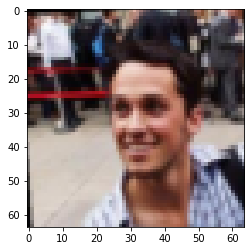

In [20]:
number = trial_number-1
# test_image = torch.tensor(np.zeros(shape = (1,3,red_dim,red_dim)))

test_name = train_data.iloc[number,0]
print('name:', name)

test_file_path = path + test_name + '/'+ test_name + '_0001' +'.jpg'
test_image = img2tensor(test_file_path)

plt.imshow(test_image.permute(1, 2, 0)  )

torch.Size([3, 64, 64])
torch.Size([12288])
torch.Size([12288])
torch.Size([3, 64, 64])


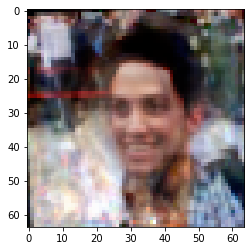

In [21]:
test_ip_image = test_image.type(torch.float32)
print(test_ip_image.size())
test_ip_image = torch.flatten(to_var(test_ip_image.view(test_ip_image.size(0), -1)))
print(test_ip_image.size())
test_recon_image = ae(test_ip_image)
test_recon_image = test_recon_image.type(torch.float32)
print(test_recon_image.size())
# test_recon_loss = loss(test_recon_image, test_ip_image)
# print('Loss:', test_recon_loss)
test_recon_image = test_recon_image.reshape(3,red_dim,red_dim)
print(recon_image.size())


transform_toimage = transforms.ToPILImage()

plt.imshow(transform_toimage(test_recon_image))